## Seattle AirBnB

This notebook is to explore AirBnB data for Seattle. The findings of this study will be posted as a blog post.

Here we will be go through the datasets from Airbnb homes of Seattle, and exploring through this notebook the calendar and listings data. More details about the project, software, data files, etc are available in the Readme.md file of the project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
calendar = pd.read_csv('calendar.csv')
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


We can see here that each listing in the calendar have a listing ID, Date, Availability (True or False) and price.
Some of the prices are not available and are reflected as NaN.

Also we need to remove the $ sign so that we can use price as numeric field.

In [3]:
def remove_dollar(column_name, dataset_name):
    ''' 
    The function will remove dollar from the given dataset and column
    '''
    dataset_name[column_name] = dataset_name[column_name].str.replace('$','').str.replace(',','');

In [4]:
def make_numeric(column_name, dataset_name):
    ''' 
    The function will convert dataset to numeric type
    '''
    dataset_name[column_name] = pd.to_numeric(dataset_name[column_name]);

In [5]:
remove_dollar('price', calendar)
make_numeric('price', calendar)
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


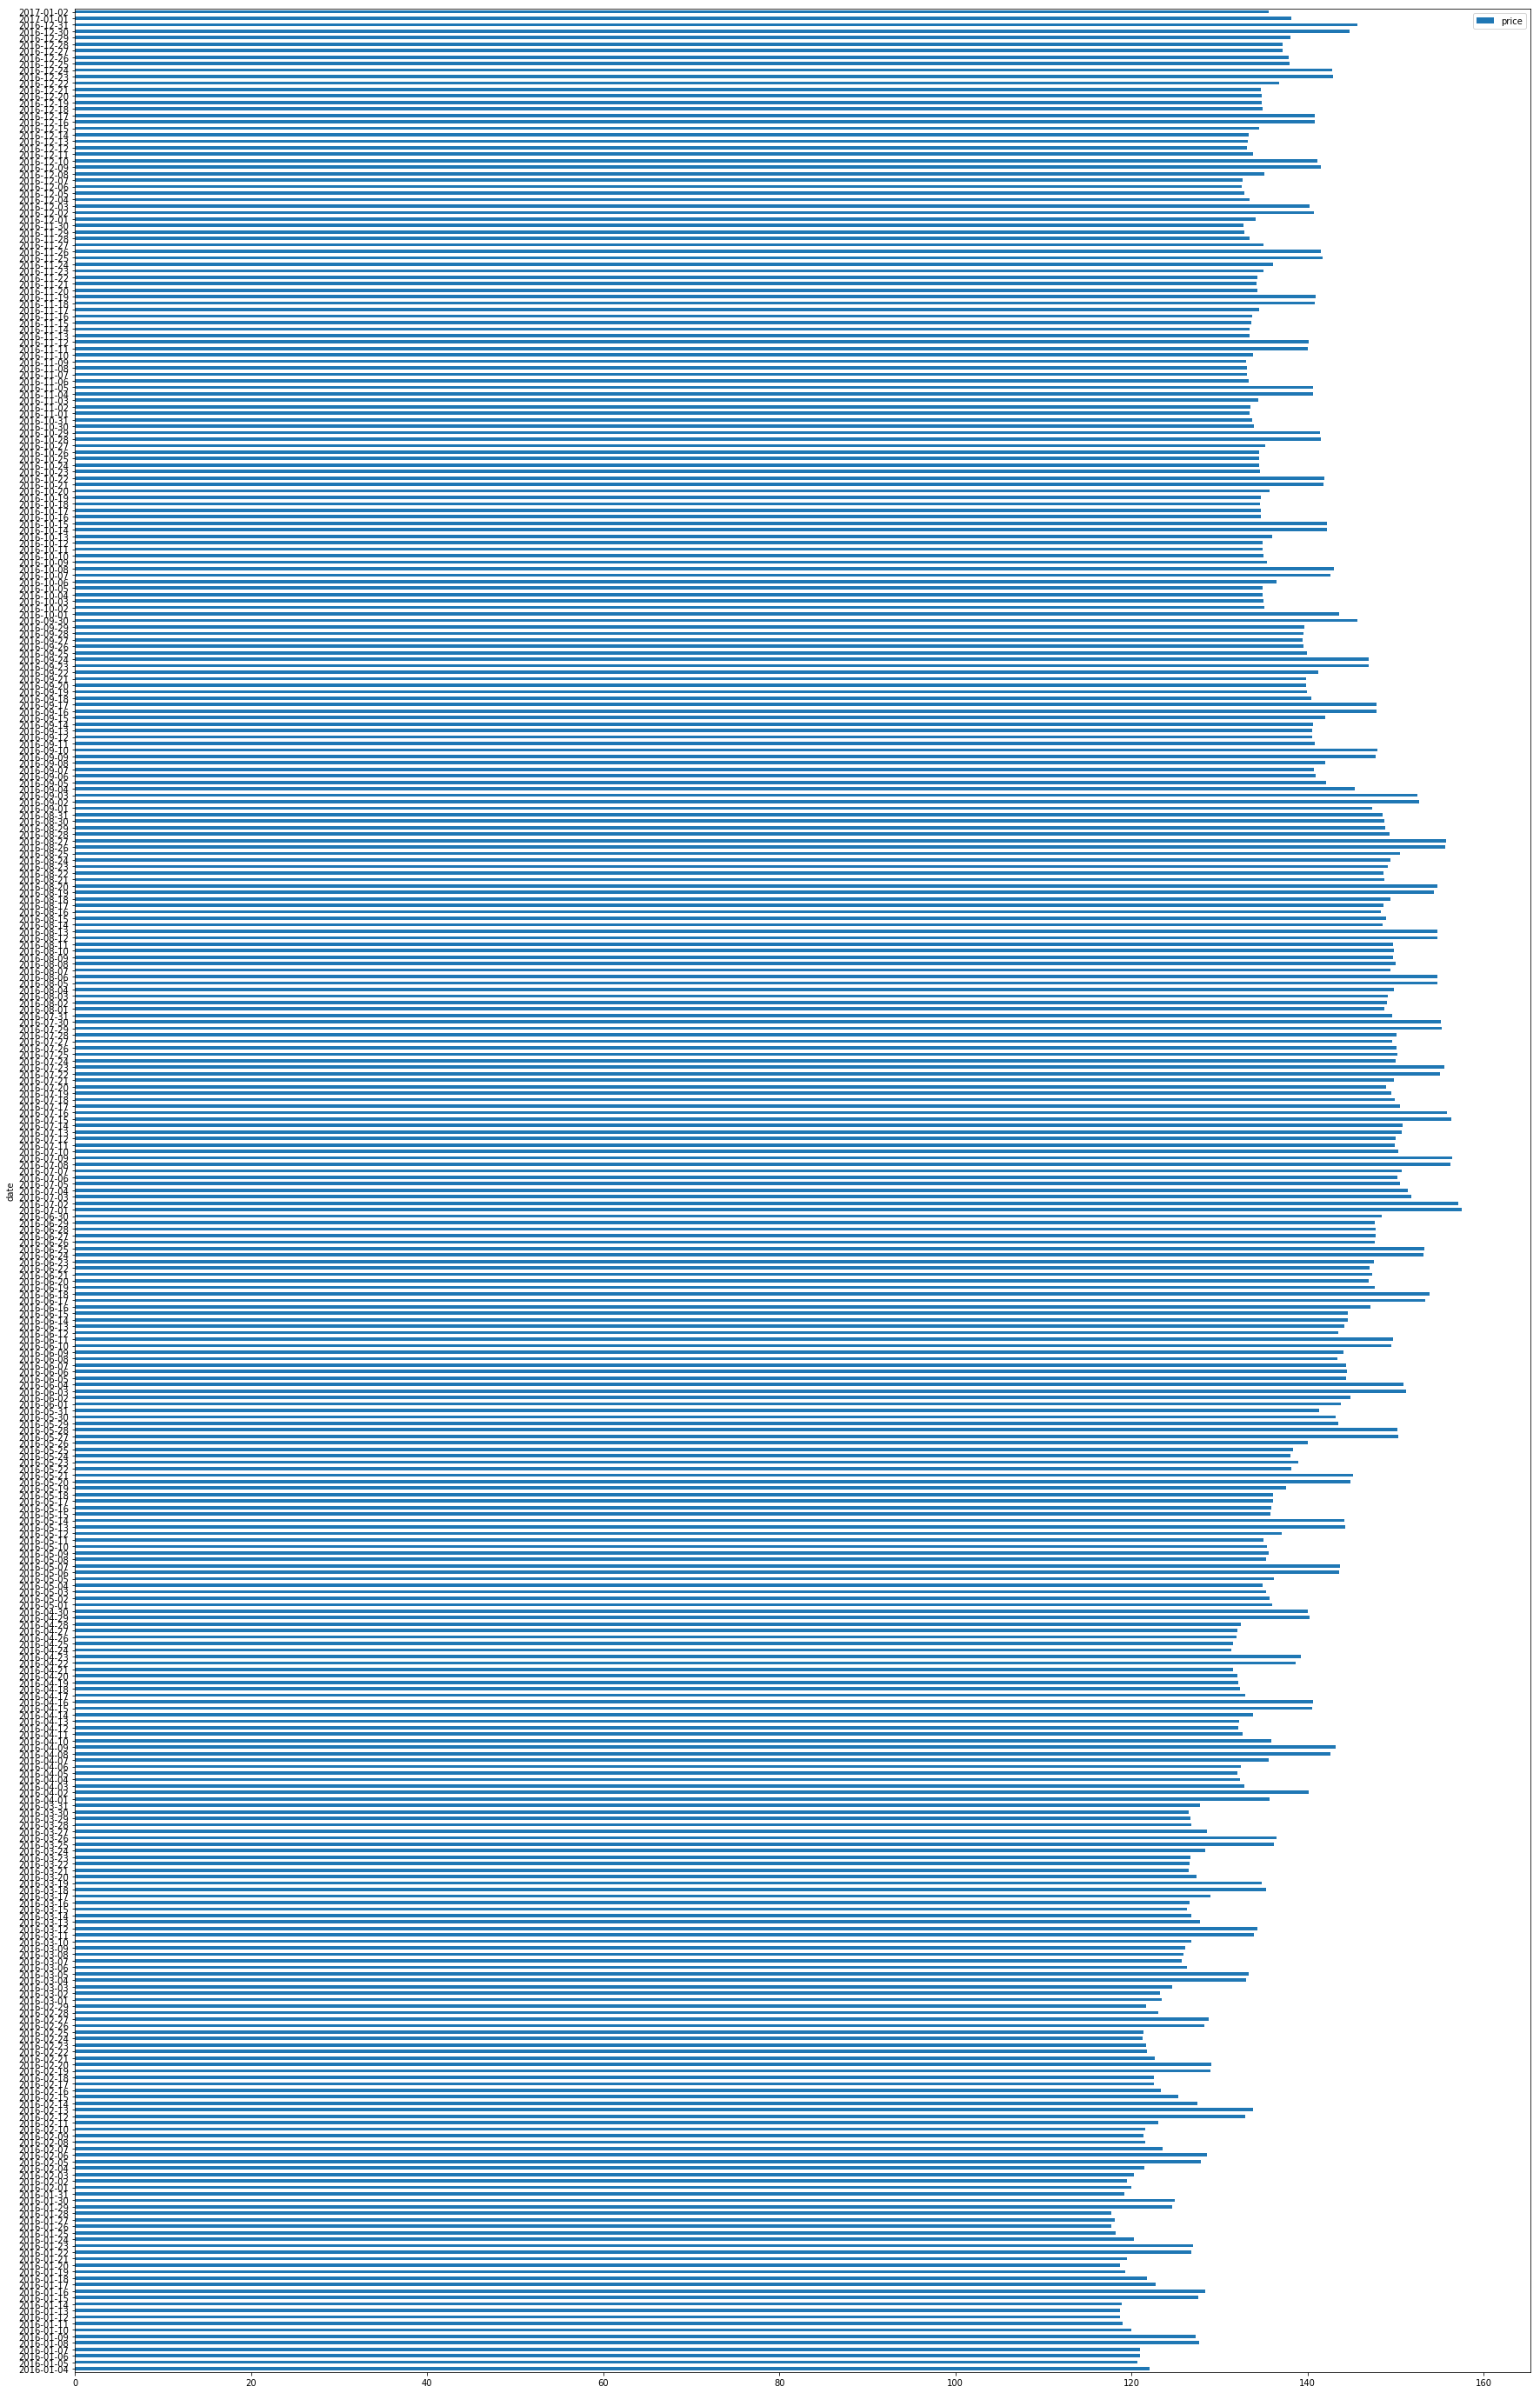

In [6]:
# Lets see how the prices trend by the days. 
# We will group prices and take a mean to get around NaN values
day_mean = pd.DataFrame(calendar.query("available == 't'").groupby(['date']).mean()['price'])

day_mean.plot(kind = 'barh',figsize = (30,50));

The above graph shows us how the mean prices change over the year.
We notice that the prices shoot up on every weekend, irrespective of the time of the year. 
We also notice that the prices start low, then they increase around middle of the year and again they fall. To get a better clarity into this, lets convert the dates into months and recreate this graph.

In [7]:
calendar['Month'] = pd.to_datetime(calendar['date'])

In [8]:
calendar = calendar.sort_values('Month', ascending=False)

In [9]:
month_mean = calendar.groupby(calendar['Month'].dt.strftime('%B'),
                                 sort=False)['price'].mean()


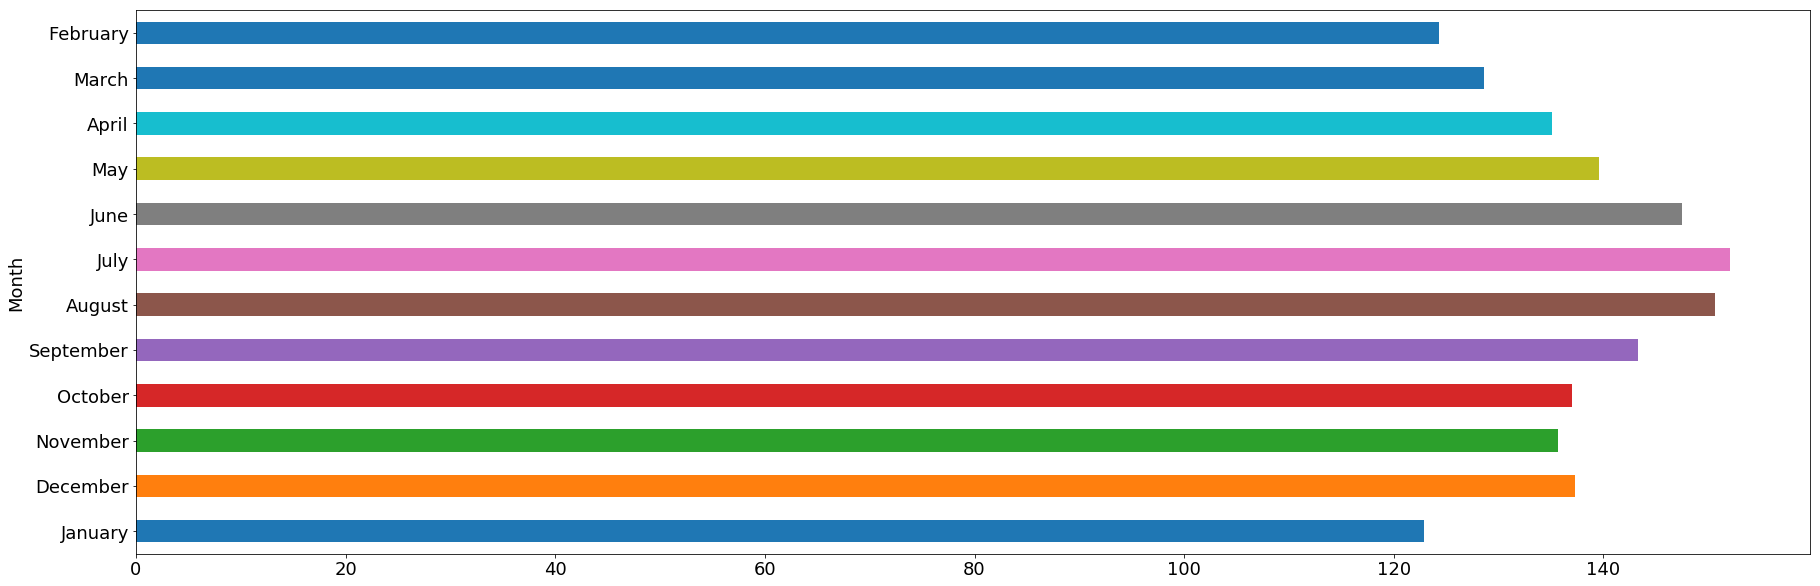

In [10]:
plt.rcParams.update({'font.size': 18})
month_mean.plot(kind = 'barh' , figsize = (30,10));

It is now clearly visible that the prices of houses are at their peak from June to August and are lowest from January to March

## Neighbourhood Analysis

Now lets move on to the listing data set and explore the same

In [11]:
listings = pd.read_csv('listings.csv')
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [12]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


There are 92 features that are present but to understand the neighbourhood we are specifically interested in - property_type, room_type, neighbourhood, neighbourhood_cleansed and zipcode

In [13]:
columns_neighbourhood = ['id', 'property_type', 'room_type', 'neighbourhood', 'neighbourhood_cleansed',
               'zipcode', 'price']

listings_neighbourhood = listings[columns_neighbourhood]
listings_neighbourhood.head()

,id,property_type,room_type,neighbourhood,neighbourhood_cleansed,zipcode,price
0,241032,Apartment,Entire home/apt,Queen Anne,West Queen Anne,98119,$85.00
1,953595,Apartment,Entire home/apt,Queen Anne,West Queen Anne,98119,$150.00
2,3308979,House,Entire home/apt,Queen Anne,West Queen Anne,98119,$975.00
3,7421966,Apartment,Entire home/apt,Queen Anne,West Queen Anne,98119,$100.00
4,278830,House,Entire home/apt,Queen Anne,West Queen Anne,98119,$450.00


In [14]:
# Lets describe each of the features
listings_neighbourhood.describe(include='all')

,id,property_type,room_type,neighbourhood,neighbourhood_cleansed,zipcode,price
count,3.818000e+03,3817,3818,3402,3818,3811,3818
unique,NaN,16,3,81,87,28,273
top,NaN,House,Entire home/apt,Capitol Hill,Broadway,98122,$150.00
freq,NaN,1733,2541,351,397,420,162
mean,5.550111e+06,NaN,NaN,NaN,NaN,NaN,NaN
std,2.962660e+06,NaN,NaN,NaN,NaN,NaN,NaN
min,3.335000e+03,NaN,NaN,NaN,NaN,NaN,NaN
25%,3.258256e+06,NaN,NaN,NaN,NaN,NaN,NaN
50%,6.118244e+06,NaN,NaN,NaN,NaN,NaN,NaN
75%,8.035127e+06,NaN,NaN,NaN,NaN,NaN,NaN



 property_type 



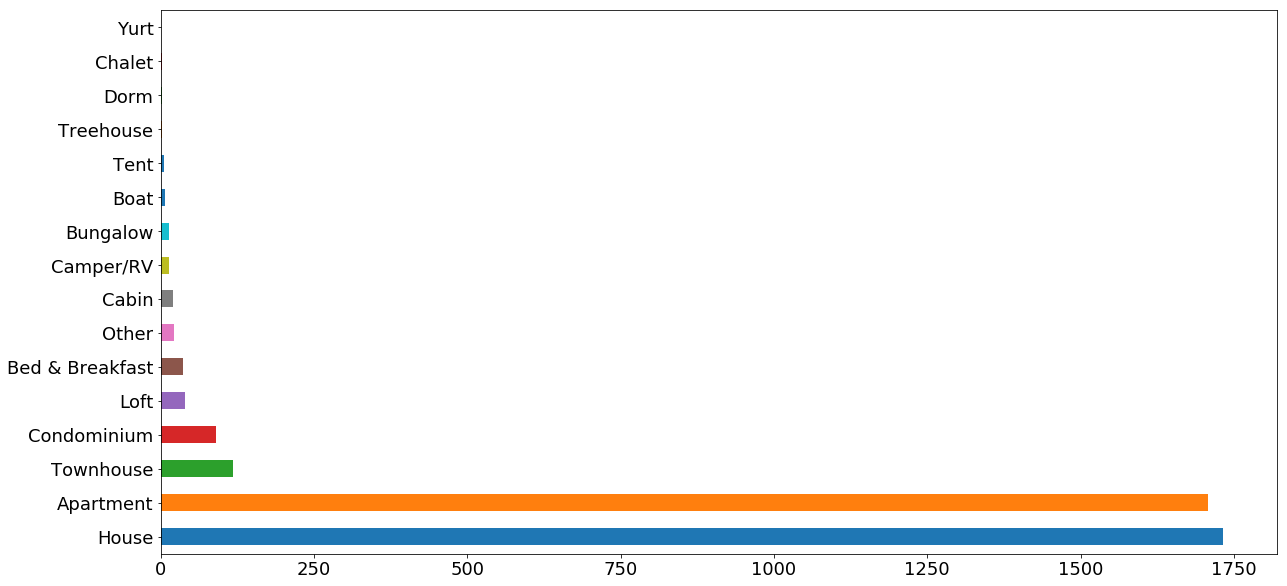

In [15]:
# Lets analyse the listing by different Property Type
count_values = ['neighbourhood', 'neighbourhood_cleansed', 'property_type', 'room_type']

def plot_value (col):
    print('\n', col ,'\n' )
    listings_neighbourhood[col].value_counts().plot(kind = 'barh' , figsize = (20,10));
    
plot_value ('property_type')
    

Great, this helps us understand the spread of various accommodation typers. Lets now move on to wrangle the data:

* Remove dollar sign and convert it into numeric data type
* Wrangle the feature property_type since all other categories except Apartment and Houses havevery few values in them so we can combine them as others.
* We can drop neighbourhood, zipcode since neighbourhood_cleansed is clean and more efficient

In [16]:
remove_dollar('price', listings_neighbourhood)
make_numeric('price', listings_neighbourhood)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [17]:
listings_neighbourhood.describe()

,id,price
count,3.818000e+03,3818.000000
mean,5.550111e+06,127.976166
std,2.962660e+06,90.250022
min,3.335000e+03,20.000000
25%,3.258256e+06,75.000000
50%,6.118244e+06,100.000000
75%,8.035127e+06,150.000000
max,1.034016e+07,1000.000000


In [18]:
# Lets replace any value that repated 30 times or less to ''other''

prop_tp = listings_neighbourhood['property_type'].value_counts()
for c in range(len(prop_tp)):
    val = prop_tp.values[c] 
    ind = prop_tp.index[c]
    if val <= 30:
        listings_neighbourhood['property_type']=listings_neighbourhood['property_type'].replace(ind,'Other');

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
listings_neighbourhood = listings_neighbourhood.drop(['neighbourhood', 'zipcode'] , axis = 1)

In [20]:
listings_neighbourhood.head()

,id,property_type,room_type,neighbourhood_cleansed,price
0,241032,Apartment,Entire home/apt,West Queen Anne,85.0
1,953595,Apartment,Entire home/apt,West Queen Anne,150.0
2,3308979,House,Entire home/apt,West Queen Anne,975.0
3,7421966,Apartment,Entire home/apt,West Queen Anne,100.0
4,278830,House,Entire home/apt,West Queen Anne,450.0


In [21]:
neighbourhood_count = pd.DataFrame()
neighbourhood_count['count'] = listings_neighbourhood['neighbourhood_cleansed'].value_counts()
neighbourhood_mean = pd.DataFrame()
neighbourhood_mean['mean_price'] = listings_neighbourhood.groupby(listings_neighbourhood['neighbourhood_cleansed'])['price'].mean()
neighbourhood_info = pd.merge(neighbourhood_mean, neighbourhood_count, left_on = neighbourhood_mean.index,right_on = neighbourhood_count.index)

In [22]:
neighbourhood_info.index = neighbourhood_info.key_0

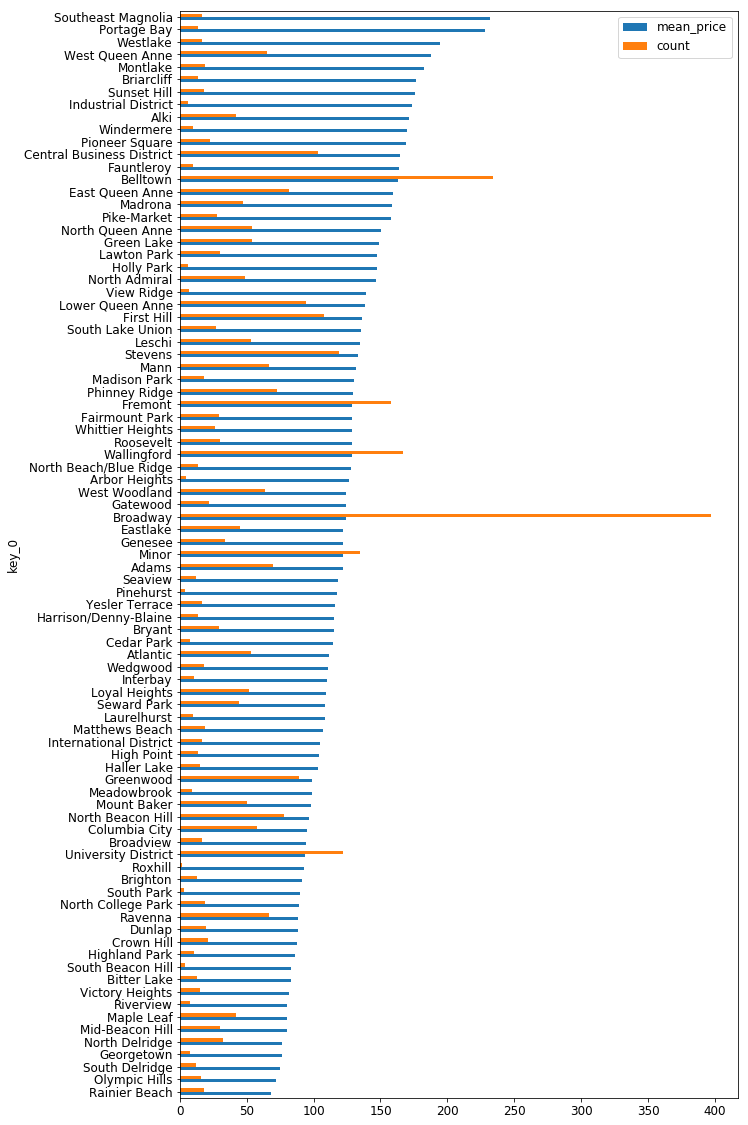

In [23]:
plt.rcParams.update({'font.size': 12})
neighbourhood_info.sort_values(by = 'mean_price').plot(kind = 'barh',figsize = (10,20));

From the above analysis we see that the neighbourhoods of Southeast Magnolia, Portage Bay and Westlake have highest mean price, while the neighbourhoods of Rainier Beach, Olympic Hills and South Delridge have lowest mean prices.

Similarily we see that the neighbourhoods of Broadway, Belltown and Wallingford have highest listing counts, while neighbourhoods of Roxhill, South Park and Pinehurst have lower listing counts


## Correlation of Features With Prices

Let's now explore the relationship between various features and the property prices in Seattle, which can be used to predict the prices of AirB&B property listings.

We will start by data cleansing for this purpose.


In [24]:
object = []
non_object = []
for col_id in range(listings.shape[1]):
    col_name = listings.columns[col_id]
    col_data_type = listings[col_name].dtypes
    if col_data_type == 'object':
        object.append(col_name)
    else : non_object.append(col_name)

print('Number of object type is', len(object), 'Number of non object type is:', len(non_object) )

Number of object type is 62 Number of non object type is: 30


Lets understaning how these features spread and their NaN values

In [25]:
hist_unique_object = []
hist_null_object = []

for col_name in object:
    count_unique_val = listings[col_name].value_counts().count()
    col_null_count = listings[col_name].isnull().sum()
    hist_unique_object.append(count_unique_val)
    hist_null_object.append(col_null_count)

In [26]:
hist_unique_non_object = []
hist_null_non_object = []

for col_name in non_object:
    count_unique_val = listings[col_name].value_counts().count()
    col_null_count = listings[col_name].isnull().sum()
    hist_unique_non_object.append(count_unique_val)
    hist_null_non_object.append(col_null_count)

In [27]:
def plot_list(dataframe, title1):
    ''' Take a dataframe and title then plot them
    '''
    plt.figure(figsize =(20,10))
    plt.title(title1)
    plt.xticks(np.arange(min(dataframe), max(dataframe), 70))
    plt.hist(dataframe, bins = np.arange(min(dataframe), max(dataframe) + 70, 70) , facecolor='blue')
    plt.show();

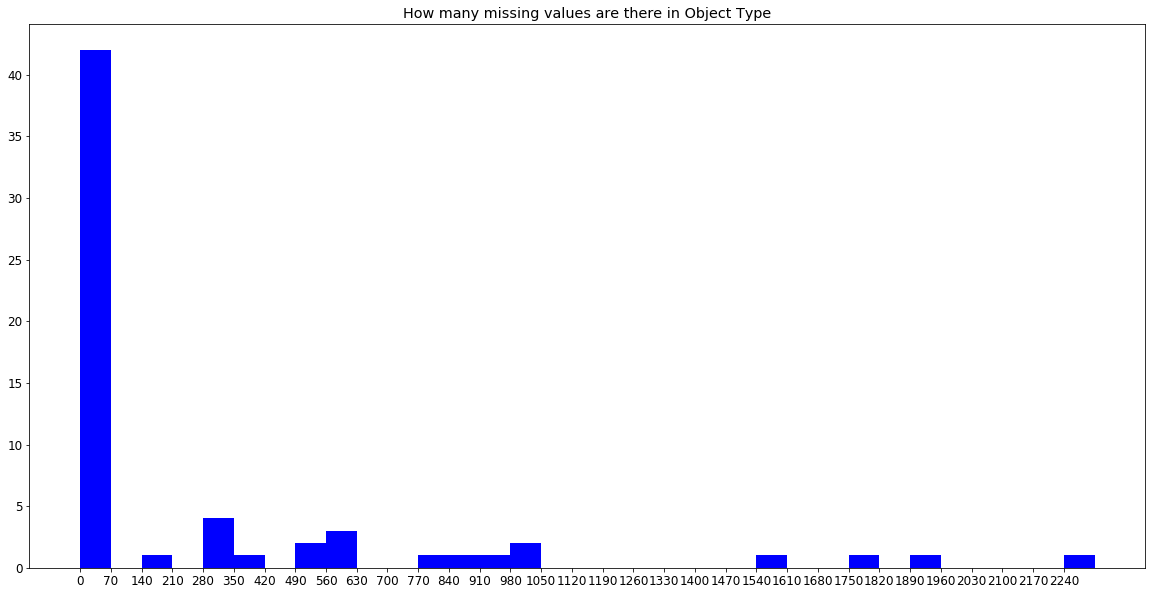

In [28]:
plot_list(hist_null_object, 'How many missing values are there in Object Type')


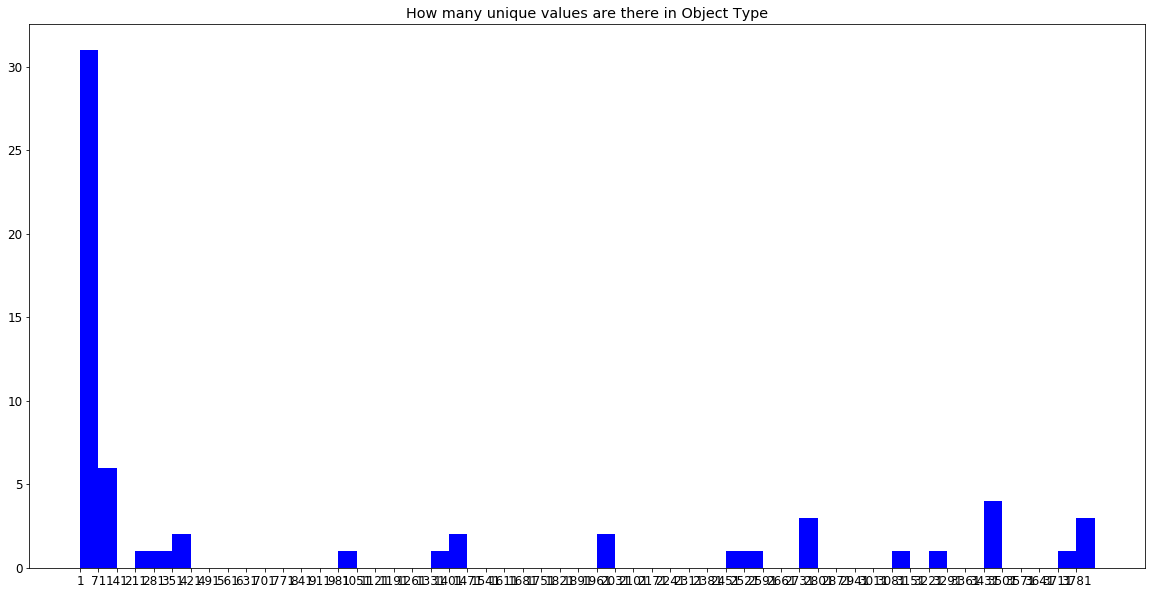

In [29]:
plot_list(hist_unique_object, 'How many unique values are there in Object Type')


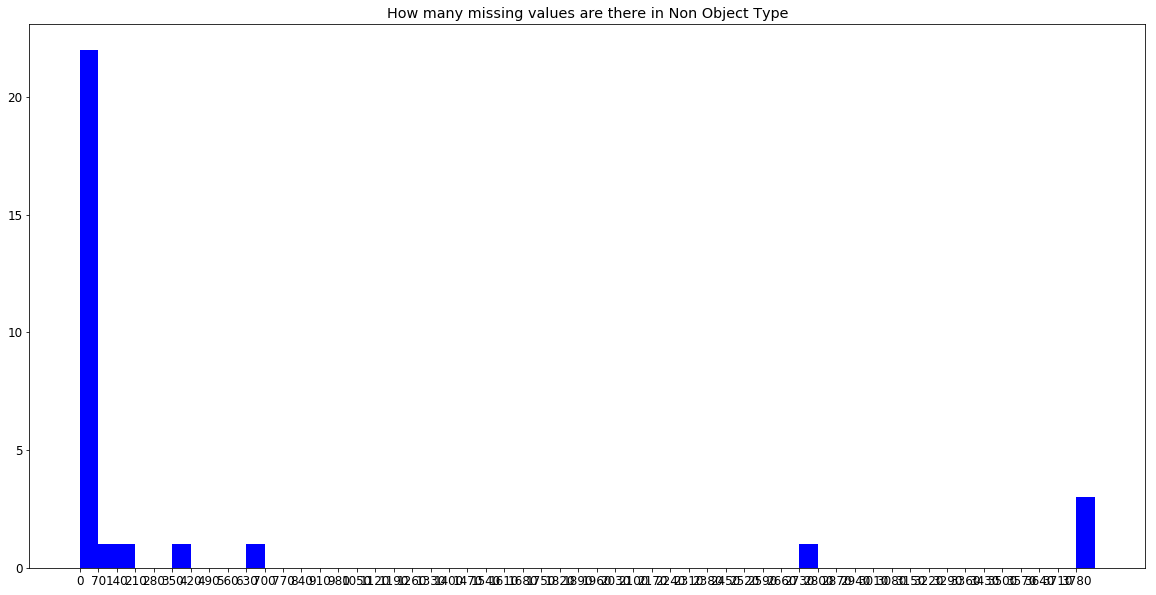

In [30]:
plot_list(hist_unique_non_object, 'How many missing values are there in Non Object Type')


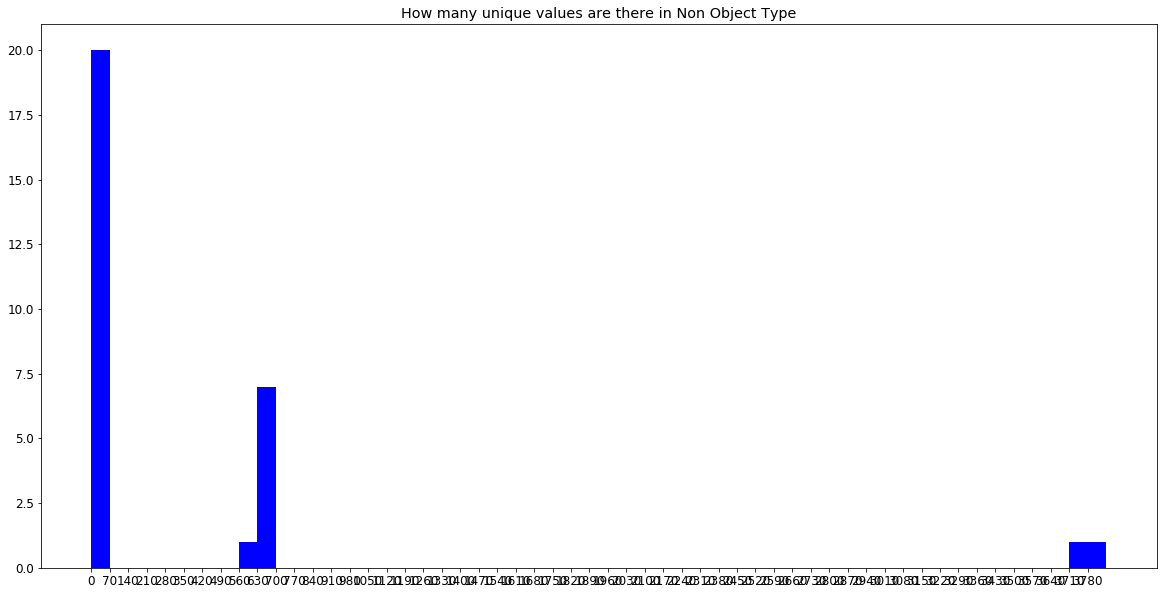

In [31]:
plot_list(hist_null_non_object, 'How many unique values are there in Non Object Type')

In [32]:
for col_name in object:
    count_unique_val = (listings[col_name].value_counts().count() / listings.shape[0]) * 100
    col_null_count = (listings[col_name].isnull().sum() / listings.shape[0]) * 100
    if col_null_count >= 30:
        print(col_name, col_null_count, '% Have of missing data')
    if count_unique_val >= 30:
        print(col_name, count_unique_val, '% Have of unique data')

listing_url 100.0 % Have of unique data
name 99.3190151912 % Have of unique data
summary 91.0948140388 % Have of unique data
space 81.6919853326 % Have of unique data
description 98.0094290204 % Have of unique data
neighborhood_overview 65.636458879 % Have of unique data
notes 42.0639078051 % Have of missing data
notes 52.3572551074 % Have of unique data
transit 67.4174960712 % Have of unique data
thumbnail_url 91.6186485071 % Have of unique data
medium_url 91.6186485071 % Have of unique data
picture_url 100.0 % Have of unique data
xl_picture_url 91.6186485071 % Have of unique data
host_url 72.0534311158 % Have of unique data
host_name 38.397066527 % Have of unique data
host_since 36.1445783133 % Have of unique data
host_about 52.6715557884 % Have of unique data
host_thumbnail_url 71.8438973284 % Have of unique data
host_picture_url 71.8438973284 % Have of unique data
street 37.768465165 % Have of unique data
amenities 86.0136196962 % Have of unique data
weekly_price 47.3808276585 % Ha

In [33]:
for col_name in non_object:
    count_unique_val = (listings[col_name].value_counts().count() / listings.shape[0]) * 100
    col_null_count = (listings[col_name].isnull().sum() / listings.shape[0]) * 100
    if col_null_count >= 30:
        print(col_name, col_null_count, '% Have of missing data')
    if count_unique_val >= 30:
            print(col_name, count_unique_val, '% Have of unique data')

id 100.0 % Have of unique data
host_id 72.0534311158 % Have of unique data
latitude 100.0 % Have of unique data
longitude 100.0 % Have of unique data
square_feet 97.4594028287 % Have of missing data
license 100.0 % Have of missing data


We will now remove any columns that will not add value by creating a new dataset and then we will handle categorical and missing data

In [34]:
listings_new = listings
listings_new = listings_new.drop(['square_feet', 'license', 'picture_url', 'listing_url', 'name', 'description', 
                                  'experiences_offered', 'latitude', 'longitude'], axis=1)

In [35]:
def data_wrangling (column_name, dataset_name, method):
    ''' Take a column_name, dataset_name and method numbers and based on method we will wrangle the feature
    '''
    # For saving changes
    count_ones,count_zeroes, count_NaA = 0,0,0

    # For counting NaN's
    count_NaN = dataset_name[column_name].isnull().sum()

    # For counting value counts in the feacture
    feature_value_counts = dataset_name[column_name].value_counts()

    for ind in range(len(feature_value_counts)):
        val = feature_value_counts.values[ind]
        ind = feature_value_counts.index[ind]

        # If method = 1 this will change repated value to 1 and non repated values to 0

        if method == 1:
            if val > 1:
                dataset_name[column_name]= dataset_name[column_name].replace(ind,1)
                count_ones = count_ones + val

            if val == 1:
                dataset_name[column_name]= dataset_name[column_name].replace(ind,0)
                count_zeroes = count_zeroes + val

        # If method = 0 this will change values to 1 and if nan will treat later with -1

        if method == 0:
            dataset_name[column_name]= dataset_name[column_name].replace(ind,1)
            count_ones =+ val

    print('For col {}, we have changed {} values to 1 , {} to 0, and {} to -1'.format(column_name, count_ones, count_zeroes, count_NaN))
    dataset_name[column_name] = dataset_name[column_name].fillna(-1)


In [36]:
col_repeat = ['host_id', 'summary', 'space','thumbnail_url', 'neighborhood_overview', 'transit', 'medium_url',
              'xl_picture_url' , 'host_url', 'host_name', 'host_about','host_thumbnail_url', 'amenities', 'host_picture_url']
col_null = ['notes', 'weekly_price', 'monthly_price', 'security_deposit', 'host_response_time', 'host_acceptance_rate']


# Fix repeated values and null values
    
for col1 in col_repeat:
    data_wrangling (col1, listings_new, 1)
for col2 in col_null:
    data_wrangling (col2, listings_new, 0)

For col host_id, we have changed 1533 values to 1 , 2285 to 0, and 0 to -1
For col summary, we have changed 251 values to 1 , 3390 to 0, and 177 to -1
For col space, we have changed 196 values to 1 , 3053 to 0, and 569 to -1
For col thumbnail_url, we have changed 0 values to 1 , 3498 to 0, and 320 to -1
For col neighborhood_overview, we have changed 434 values to 1 , 2352 to 0, and 1032 to -1
For col transit, we have changed 458 values to 1 , 2426 to 0, and 934 to -1
For col medium_url, we have changed 0 values to 1 , 3498 to 0, and 320 to -1
For col xl_picture_url, we have changed 0 values to 1 , 3498 to 0, and 320 to -1
For col host_url, we have changed 1533 values to 1 , 2285 to 0, and 0 to -1
For col host_name, we have changed 2930 values to 1 , 886 to 0, and 2 to -1
For col host_about, we have changed 1352 values to 1 , 1607 to 0, and 859 to -1
For col host_thumbnail_url, we have changed 1540 values to 1 , 2276 to 0, and 2 to -1
For col amenities, we have changed 833 values to 1 ,

In [37]:
# Reduce host_since values and remove days
reduce_date = ['first_review' , 'last_review', 'host_since']
for col in reduce_date:
    new_list = listings_new[col].value_counts()
    for l in range(len(new_list)):
        val = new_list.values[l]
        ind = new_list.index[l]
        listings_new[col]=listings_new[col].replace(ind,ind[:-6])

print ("To reduce features we have removed days & months columns in following features - 'first_review' , 'last_review', 'host_since'")


To reduce features we have removed days & months columns in following features - 'first_review' , 'last_review', 'host_since'


In [38]:
# Reduce host_nighbourhood with less features

new_list = listings_new['host_neighbourhood'].value_counts()
for l in range(len(new_list)):
    val = new_list.values[l]
    ind = new_list.index[l]
    if val <= 20:
        listings_new['host_neighbourhood']=listings_new['host_neighbourhood'].replace(ind,1)

print ("We have reduced host neighbourhoods with less features")


We have reduced host neighbourhoods with less features


In [39]:
# Reduce values of street

listings_new['street'] = listings_new['street'].str.split(',').str[0]
new_list = listings_new['street'].value_counts()

for l in range(len(new_list)):
    val = new_list.values[l]
    ind = new_list.index[l]
    if val <= 10:
        listings_new['street']=listings_new['street'].replace(ind,'others')
        
print ('We have removed streets which repeated 10 or less times in the dataset')

We have removed streets which repeated 10 or less times in the dataset


In [40]:
# Fix some data issues

# Fix Zip code
listings_new['zipcode']=listings_new['zipcode'].replace('99\n98122','98122')

# Replace $ sign
listings_new['cleaning_fee'] = listings_new['cleaning_fee'].str.replace('$','').str.replace(',','')
listings_new['price'] = listings_new['price'].str.replace('$','').str.replace(',','')
listings_new['extra_people'] = listings_new['extra_people'].str.replace('$','').str.replace(',','')

# Include only hosts from seattle
listings_new['host_location'] = listings_new['host_location'].str.contains('Seattle')

# Replace % sign to number
listings_new['host_response_rate'] = listings_new['host_response_rate'].str.replace('%','')

print('We have fixed data  issues related to zipcode, $ sign, % sign and non-Seattle hosts in following columns extra_people, price, cleaning_fee, zipcode,host_response_rate, host_location')


We have fixed data  issues related to zipcode, $ sign, % sign and non-Seattle hosts in following columns extra_people, price, cleaning_fee, zipcode,host_response_rate, host_location


In [41]:
# Reduce unnecessary features from calendar_updated

new_list = listings_new['calendar_updated'].value_counts()
for l in range(len(new_list)):
    val = new_list.values[l]
    ind = new_list.index[l]
    if 'days' in ind or 'week' in ind:
        listings_new['calendar_updated']=listings_new['calendar_updated'].replace(ind,'week')
    if 'months' in ind :
        listings_new['calendar_updated']=listings_new['calendar_updated'].replace(ind,'months')
    if 'yesterday' in ind:
        listings_new['calendar_updated']=listings_new['calendar_updated'].replace(ind,'today')
                                                              
print('We have removed unnecassry features from calendar_updated')

We have removed unnecassry features from calendar_updated


In [42]:
# Fixing NaNs

fill_NaNs = ['host_location','host_response_rate','host_is_superhost', 'host_neighbourhood','host_has_profile_pic', 'host_since',
             'host_identity_verified' , 'neighbourhood', 'zipcode', 'property_type', 'cleaning_fee', 'first_review' , 'last_review' ]
for col3 in fill_NaNs:
    count_NaN = listings_new[col3].isnull().sum()
    listings_new[col3] = listings_new[col3].fillna(-1)
    print(col3, "we have fixed", count_NaN, 'nan data and changed to -1' )

host_location we have fixed 8 nan data and changed to -1
host_response_rate we have fixed 523 nan data and changed to -1
host_is_superhost we have fixed 2 nan data and changed to -1
host_neighbourhood we have fixed 300 nan data and changed to -1
host_has_profile_pic we have fixed 2 nan data and changed to -1
host_since we have fixed 2 nan data and changed to -1
host_identity_verified we have fixed 2 nan data and changed to -1
neighbourhood we have fixed 416 nan data and changed to -1
zipcode we have fixed 7 nan data and changed to -1
property_type we have fixed 1 nan data and changed to -1
cleaning_fee we have fixed 1030 nan data and changed to -1
first_review we have fixed 627 nan data and changed to -1
last_review we have fixed 627 nan data and changed to -1


In [43]:
# converting to Numeric

to_numeric = ['cleaning_fee', 'price', 'extra_people', 'host_response_rate' ]

for col_n in to_numeric:
    listings_new[col_n] = pd.to_numeric(listings_new[col_n])

print("We have changed following to numeric type 'cleaning_fee', 'price', 'extra_people', 'host_response_rate' ")

We have changed following to numeric type 'cleaning_fee', 'price', 'extra_people', 'host_response_rate' 


In [44]:
def bag_of_words (column_name, dataset_name):
    ''' Take a column_name, dataset_name as inputs and create the bag of words 
    '''
    bag_of_words = CountVectorizer()
    vectorizer_data = bag_of_words.fit_transform(dataset_name[column_name]).toarray()
    vectorizer_names = bag_of_words.get_feature_names()
    names_vectors = []
    new_name = column_name + '_'
    for name in vectorizer_names:
        names_vectors.append(new_name + name)
    df = pd.DataFrame(vectorizer_data, columns = names_vectors)
    for col in df.columns:
        sum_cols =  df[col].sum() / df.shape[0]
        if sum_cols < 0.3:
            df = df.drop(col, axis = 1)
    dataset_name = dataset_name.join(df)

    return dataset_name

In [45]:
pre_final = bag_of_words ('host_verifications', listings_new)

In [46]:
pre_final = pre_final.drop('host_verifications', axis = 1)

In [47]:
objects = []
non_objects = []
for col_id in range(pre_final.shape[1]):
    col_name = pre_final.columns[col_id]
    col_data_type = pre_final[col_name].dtypes
    if col_data_type == 'object':
        objects.append(col_name)
    else : non_object.append(col_name)

print('Number of object type is', len(objects), 'Number of non object type is:', len(non_objects) )

Number of object type is 33 Number of non object type is: 0


In [48]:
for col_n in objects:
    count_unique_val = pre_final[col_n].value_counts().count()
    if count_unique_val == 1:
        pre_final = pre_final.drop(col_n, axis = 1)
        print('We have drop',col_n, 'due is have one value')

We have drop last_scraped due is have one value
We have drop market due is have one value
We have drop country_code due is have one value
We have drop country due is have one value
We have drop has_availability due is have one value
We have drop calendar_last_scraped due is have one value
We have drop requires_license due is have one value
We have drop jurisdiction_names due is have one value


In [49]:
pre_final = pre_final.drop('state', axis = 1)

In [50]:
object_cols = []
non_object_cols = []
for colid in range(pre_final.shape[1]):
    col_name = pre_final.columns[colid]
    col_data_type = pre_final[col_name].dtypes
    if col_data_type == 'object':
        object_cols.append(col_name)
    else : non_object_cols.append(col_name)
        
for col_n in object_cols:
    count_unique_val = pre_final[col_n].value_counts().count()
    if count_unique_val == 2:
        pre_final[col_n]=pre_final[col_n].replace('t',1)
        pre_final[col_n]=pre_final[col_n].replace('f',0)
        pre_final[col_n] = pd.to_numeric(pre_final[col_n])
        print(col_n, 'hase change to numeric')

is_location_exact hase change to numeric
instant_bookable hase change to numeric
require_guest_profile_picture hase change to numeric
require_guest_phone_verification hase change to numeric


In [51]:
pre_final['host_location'] = pre_final['host_location'].replace('True',1)
pre_final['host_location'] = pre_final['host_location'].replace('False',0)
pre_final['host_location'] = pd.to_numeric(pre_final['host_location'])
pre_final['host_is_superhost'] = pre_final['host_is_superhost'].replace('t',1)
pre_final['host_is_superhost'] = pre_final['host_is_superhost'].replace('f',0)
pre_final['host_is_superhost'] = pd.to_numeric(pre_final['host_is_superhost'])
pre_final['host_has_profile_pic'] = pre_final['host_has_profile_pic'].replace('t',1)
pre_final['host_has_profile_pic'] = pre_final['host_has_profile_pic'].replace('f',0)
pre_final['host_has_profile_pic'] = pd.to_numeric(pre_final['host_has_profile_pic'])
pre_final['host_identity_verified'] = pre_final['host_identity_verified'].replace('t',1)
pre_final['host_identity_verified'] = pre_final['host_identity_verified'].replace('f',0)
pre_final['host_identity_verified'] = pd.to_numeric(pre_final['host_identity_verified'])

print('host_is_superhost, host_has_profile_pic, host_identity_verified has been changed to numeric')

host_is_superhost, host_has_profile_pic, host_identity_verified has been changed to numeric


In [52]:
pre_final = pre_final.drop(['neighbourhood', 'neighbourhood_group_cleansed', 'city', 'smart_location'], axis = 1)

In [53]:
objects = []
non_objects = []
for colid in range(pre_final.shape[1]):
    col_name = pre_final.columns[colid]
    col_data_type = pre_final[col_name].dtypes
    if col_data_type == 'object':
        objects.append(col_name)
    else : non_objects.append(col_name)
objects

['host_since',
 'host_neighbourhood',
 'street',
 'neighbourhood_cleansed',
 'zipcode',
 'property_type',
 'room_type',
 'bed_type',
 'calendar_updated',
 'first_review',
 'last_review',
 'cancellation_policy']

In [54]:
final = pre_final
for col_name in objects:
    df = pd.get_dummies(final[col_name], prefix=col_name , drop_first=True)
    final = final.join(df)
    final = final.drop(col_name, axis=1)
    print(col_name)

host_since
host_neighbourhood
street
neighbourhood_cleansed
zipcode
property_type
room_type
bed_type
calendar_updated
first_review
last_review
cancellation_policy


In [55]:
objects = []
non_objects = []
for col_id in range(final.shape[1]):
    col_name = final.columns[col_id]
    col_data_type = final[col_name].dtypes
    if col_data_type == 'object':
        objects.append(col_name)
    else : non_objects.append(col_name)

null_non_objects = []

for col_name in non_objects:
    col_null_count = final[col_name].isnull().sum()
    hist_null_non_object.append(col_null_count)
    if col_null_count >= 1:
        final[col_name] = final[col_name].fillna(final[col_name].mean())

With this we have now completed all necessry data wrangling tasks before building the predictive model. 
Now lets build a predictive model

In [56]:
y = final['price']
X = final.drop(['price','id','scrape_id', 'cleaning_fee', 'extra_people'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=62)

In [57]:
ForestRegressor = RandomForestRegressor(n_estimators=500)
ForestRegressor.fit(X_train, y_train)
y_test_preds = ForestRegressor.predict(X_test)
print(r2_score(y_test, y_test_preds))
print(mean_squared_error(y_test, y_test_preds))
print(median_absolute_error(y_test, y_test_preds))

0.591225426957
3212.15341275
18.444


We are getting absolute median error of $18.84 in our model which is not very accurate. 

Now lets evaluate the correlation of features, the higher the correlation coeff, the more important the feature is.

In [58]:
coeff_dataframe = pd.DataFrame()

coeff_dataframe['est_int'] = X_train.columns
coeff_dataframe['coeff'] = ForestRegressor.feature_importances_
coeff_dataframe.sort_values('coeff', ascending=False).head(20)

,est_int,coeff
26,bedrooms,0.374538
24,accommodates,0.086613
25,bathrooms,0.064889
288,room_type_Private room,0.028070
38,availability_365,0.020003
51,reviews_per_month,0.017511
289,room_type_Shared room,0.015187
39,number_of_reviews,0.013208
122,street_8th Avenue,0.011694
162,neighbourhood_cleansed_Belltown,0.011626


In [59]:
coeff_dataframe.index = coeff_dataframe.est_int


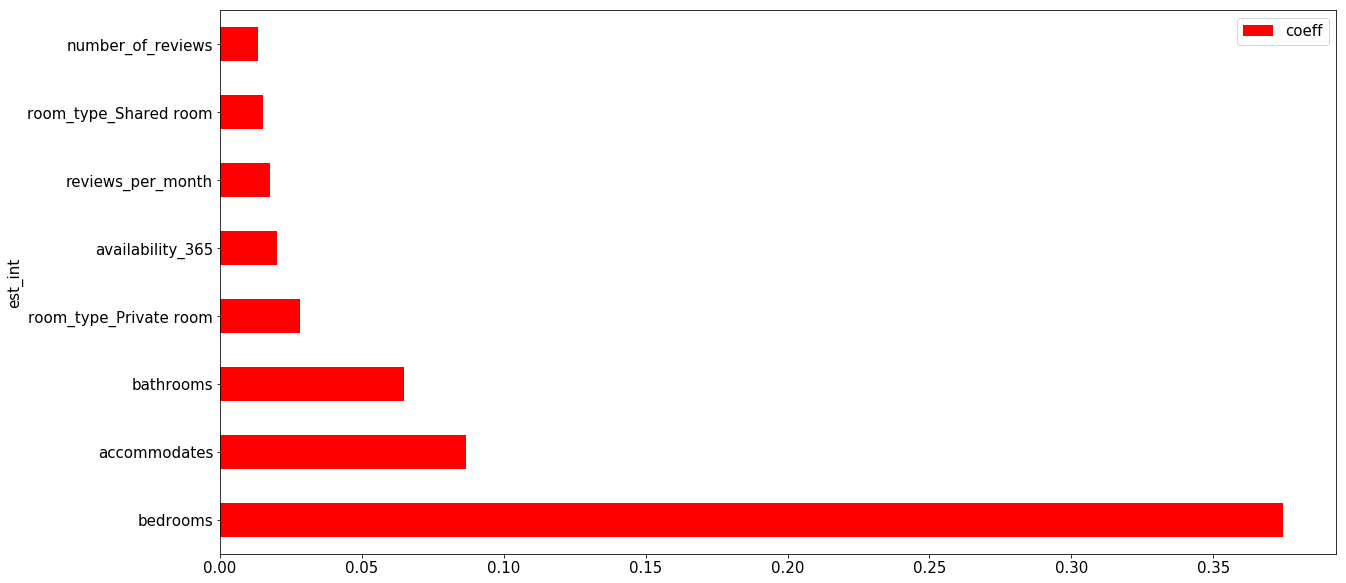

In [62]:
plt.rcParams.update({'font.size': 15})
coeff_dataframe.sort_values('coeff', ascending=False).head(8).plot(kind = 'barh',figsize = (20,10), facecolor='red');

Hence we see that Bedrooms, (person) Accomodates, bathrooms have very high correlation